In [1]:
%env XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import torch
import numpy as np
import matplotlib.pyplot as plt
import emlp
from emlp.groups import Group, S, Z, SO
from emlp.reps import V,T,vis, Scalar, Vector

env: XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


2023-01-26 00:07:58.249057: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-26 00:07:59.310751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-01-26 00:07:59.311049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory
2023-01-26 00:07:59.311062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
class CustomGroup(Group):
    def __init__(self, n, generators):
        if len(generators.shape) == 2:
            generators = np.expand_dims(generators, axis=0)
        self.lie_algebra = generators
        super().__init__(n)

In [4]:
groups = []
# 0: LieGAN 2*2 search space
G0 = torch.load('./saved_model/results/generator-2body-liegan.pt')
mask0 = torch.block_diag(torch.ones(2, 2), torch.ones(2, 2), torch.ones(2, 2), torch.ones(2, 2))
G0 = (G0['Li'][0, :, :].to('cpu') * mask0).numpy()
groups.append(CustomGroup(8, G0))
# 1: LieGAN 4*4 search space
G1 = torch.load('./saved_model/results/generator-2body-liegan-es.pt')
mask1 = torch.block_diag(torch.ones(4, 4), torch.ones(4, 4))
p = torch.eye(8)
p[4:6,2:4] = p[2:4,4:6] = torch.eye(2)
p[2:4,2:4] = p[4:6,4:6] = 0
mask = p @ mask1 @ p
G1 = (G1['Li'][0, :, :].to('cpu')).numpy()
groups.append(CustomGroup(8, G1))
# 2: Modified Augerino
G2 = torch.load('./saved_model/results/augerino-2body.pt')
G2 = (G2['aug.Li'][0, :, :].to('cpu') * mask0).numpy()
groups.append(CustomGroup(8, G2))
# 3: Ground truth
GT = np.zeros_like(G0)
GT[1,0]=GT[3,2]=GT[5,4]=GT[7,6]=-1
GT[0,1]=GT[2,3]=GT[4,5]=GT[6,7]=1
groups.append(CustomGroup(8, GT))

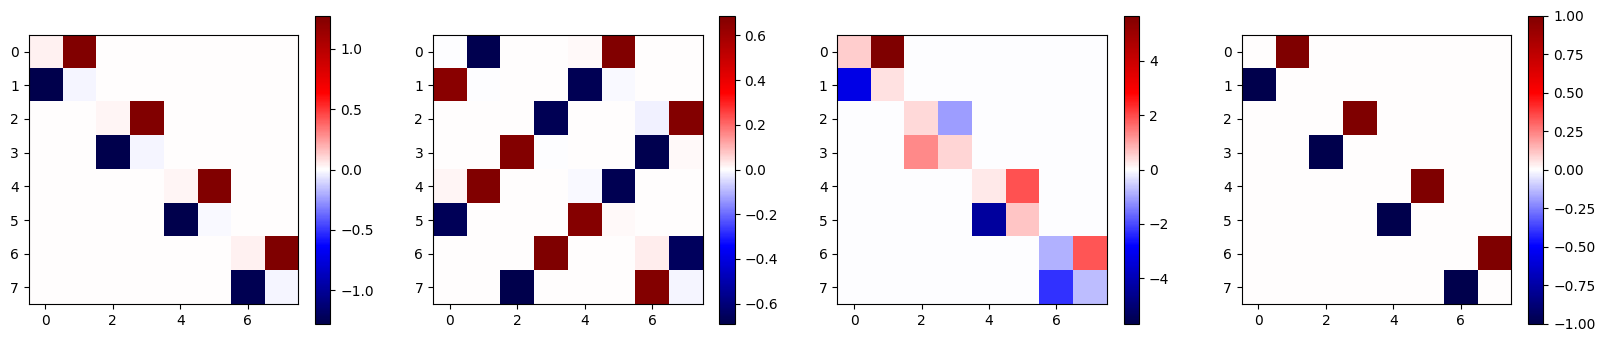

In [5]:
plt.figure(figsize=(20,4))
plt.subplot(1, 4, 1)
plt.imshow(G0, cmap='seismic', vmin=-np.max(np.abs(G0)), vmax=np.max(np.abs(G0)))
plt.colorbar()
plt.subplot(1, 4, 2)
plt.imshow(G1, cmap='seismic', vmin=-np.max(np.abs(G1)), vmax=np.max(np.abs(G1)))
plt.colorbar()
plt.subplot(1, 4, 3)
plt.imshow(G2, cmap='seismic', vmin=-np.max(np.abs(G2)), vmax=np.max(np.abs(G2)))
plt.colorbar()
plt.subplot(1, 4, 4)
plt.imshow(GT, cmap='seismic', vmin=-np.max(np.abs(GT)), vmax=np.max(np.abs(GT)))
plt.colorbar()

In [7]:
input_timesteps, output_timesteps = 5, 5
model_list = []
for G in groups:
    rep_in = Vector * input_timesteps
    rep_out = Vector * output_timesteps
    model_list.append(emlp.nn.EMLP(rep_in(G), rep_out(G), group=G, num_layers=3, ch=5*V(G)))

In [9]:
from dataset import NBodyDataset
trainset = NBodyDataset(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    trj_timesteps=20,
    save_path='./data/hnn/2body-orbits-dataset.pkl',
    flatten=True,
)
testset = NBodyDataset(
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    trj_timesteps=20,
    save_path=f'./data/hnn/2body-orbits-dataset.pkl',
    flatten=True,
    mode='test',
    with_random_transform=True
)

In [10]:
BS=1000
lr=1e-4
NUM_EPOCHS=5000

import objax
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

In [11]:
def train_model(model):
    opt = objax.optimizer.Adam(model.vars())

    @objax.Jit
    @objax.Function.with_vars(model.vars())
    def loss(x, y):
        yhat = model(x)
        return ((yhat-y)**2).mean()

    grad_and_val = objax.GradValues(loss, model.vars())

    @objax.Jit
    @objax.Function.with_vars(model.vars()+opt.vars())
    def train_op(x, y, lr):
        g, v = grad_and_val(x, y)
        opt(lr=lr, grads=g)
        return v
    
    train_losses, test_losses = [], []
    equiv_errors = []
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),lr) for (x,y) in trainloader]))
        if not epoch % 10:
            test_losses.append(np.mean([loss(jnp.array(x),jnp.array(y)) for (x,y,_,_) in testloader]))
            equiv_errors.append(np.mean([(model(jnp.array(gx)) - jnp.array(gy)) ** 2 for (_,_,gx,gy) in testloader]))
                
    return train_losses, test_losses, equiv_errors

In [12]:
def evaluate_model(model, loader):
    @objax.Jit
    @objax.Function.with_vars(model.vars())
    def loss(x, y):
        yhat = model(x)
        return ((yhat-y)**2).mean()
    
    return np.mean([loss(jnp.array(x),jnp.array(y)) for (x,y) in loader])

In [14]:
train_losses, test_losses, equiv_errors = [], [], []
for model in model_list:
    tr, ts, ee = train_model(model)
    train_losses.append(tr)
    test_losses.append(ts)
    equiv_errors.append(ee)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [17]:
mlp = emlp.nn.MLP(rep_in(groups[0]), rep_out(groups[0]), group=groups[0], num_layers=3, ch=40)
mlp_tr_loss, mlp_ts_loss, mlp_equiv_err = train_model(mlp)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# test losses
[l[-1] for l in test_losses[:]] + mlp_ts_loss[-1:]